In [1]:
# Create the network
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
from sklearn.model_selection import train_test_split


point_count = 100
cloud_count = 10000

class PointNet1D(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PointNet1D, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, output_dim)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        self.bn6 = nn.BatchNorm1d(output_dim)
        
        self.drop = nn.Dropout(p=0.3)


    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        #x = F.relu(self.drop(x))
        x = F.relu(self.bn6(self.drop(x)))
        #x = F.softmax(x, dim=1)
        return x

net = PointNet1D(point_count, 1)

In [2]:
# Function to calculate Q
def charfun(x, y, R):
    if abs(x-y) <= R:
        return 1
    return 0

# Create clouds
R = 0.1        #What do different values of R change?
data = []
Qs = []
i = 0
for k in range(cloud_count):
    if i == 0:
        i = 1
        x = np.random.normal(0.5 , 0.5, size = point_count) # C
    else:
        x = np.random.uniform(0,1,point_count)
        i = 0
    Q = sum(charfun(k, j, R) for k in x for j in x)
    Q *= 1/(len(x)**2)
    #print(Q)
    Qs.append(Q)
    data.append(x)

#Turn data in torch tensor
Qs = torch.Tensor(Qs)
data = torch.Tensor(data)

# Reshape data for network
data.unsqueeze_(2)
Qs.unsqueeze_(1)

# Split into train/ test
X_train, X_test, y_train, y_test = train_test_split(
         data, Qs, test_size=0.1, random_state=42)

#Training set batches
trainset = TensorDataset(X_train, y_train)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2, drop_last = True)

#Test set batches
#testset = TensorDataset(X_test, y_test)

#testloader = torch.utils.data.DataLoader(testset, batch_size=32,
#                                          shuffle=True, num_workers=2,  drop_last = True)

In [14]:
# Loss function and optimizer
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# Functions to find loss and accuracy
def find_loss():
    output = net(X_test)
    val_loss = criterion(output, y_test)
    return val_loss.item()

def accuracy_fun(output, labels):
    total, correct = 0.0 , 0
    for i in range(len(y_test)):
        if abs(output[i].item() - labels[i].item()) < 2 * R/5:  # This is very generous and crudge to measure the accuracy
            correct += 1
        total += 1
    return 100 * correct / total

In [4]:
# Training
training_loss = []
validep_loss = []
trainingep_loss = []
validation_loss = []
#accuracy = []
for epoch in range(30):  # loop over the dataset multiple times
    ep_counter, ep_loss = 0, 0.0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        training_loss.append(loss.detach().item())
        
        # print statistics
        running_loss += loss.item()
        ep_loss += loss.item()
        ep_counter += 1
        if i % 64 == 63:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 64))
            training_loss.append(running_loss / 64)
            running_loss = 0.0
            #accuracy.append(accuracy_fun(outputs, labels))
        validation_loss.append(find_loss())
        
    validep_loss.append(find_loss())
    trainingep_loss.append(ep_loss/ep_counter)
    ep_counter, ep_loss = 0, 0.0

print('Finished Training')

[1,    64] loss: 0.332
[1,   128] loss: 0.162
[2,    64] loss: 0.081
[2,   128] loss: 0.042
[3,    64] loss: 0.024
[3,   128] loss: 0.021
[4,    64] loss: 0.020
[4,   128] loss: 0.017
[5,    64] loss: 0.017
[5,   128] loss: 0.014
[6,    64] loss: 0.012
[6,   128] loss: 0.009
[7,    64] loss: 0.010
[7,   128] loss: 0.008
[8,    64] loss: 0.007
[8,   128] loss: 0.008
[9,    64] loss: 0.007
[9,   128] loss: 0.007
[10,    64] loss: 0.006
[10,   128] loss: 0.006
[11,    64] loss: 0.008
[11,   128] loss: 0.007
[12,    64] loss: 0.006
[12,   128] loss: 0.006
[13,    64] loss: 0.006
[13,   128] loss: 0.006
[14,    64] loss: 0.010
[14,   128] loss: 0.008
[15,    64] loss: 0.006
[15,   128] loss: 0.006
[16,    64] loss: 0.005
[16,   128] loss: 0.005
[17,    64] loss: 0.005
[17,   128] loss: 0.005
[18,    64] loss: 0.005
[18,   128] loss: 0.004
[19,    64] loss: 0.005
[19,   128] loss: 0.005
[20,    64] loss: 0.004
[20,   128] loss: 0.005
[21,    64] loss: 0.004
[21,   128] loss: 0.004
[22,    64

In [15]:
# Test final accuracy
outputs = net(X_test)
print('Accuracy of the network on the 10000 test images: %d %%' % 
          accuracy_fun(outputs, y_test))

Accuracy of the network on the 10000 test images: 68 %


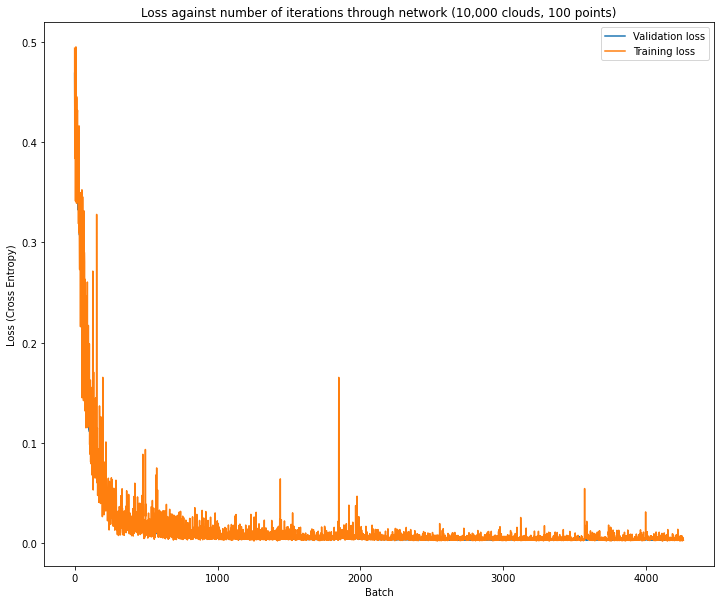

In [13]:
# Print out relevant graphs
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
plt.title('Loss against number of iterations through network (10,000 clouds, 100 points)') 
plt.xlabel('Batch')                                              
plt.ylabel('Loss (Cross Entropy)') 
plt.plot(validation_loss, label = "Validation loss")
plt.plot(training_loss, label = "Training loss")
plt.legend()

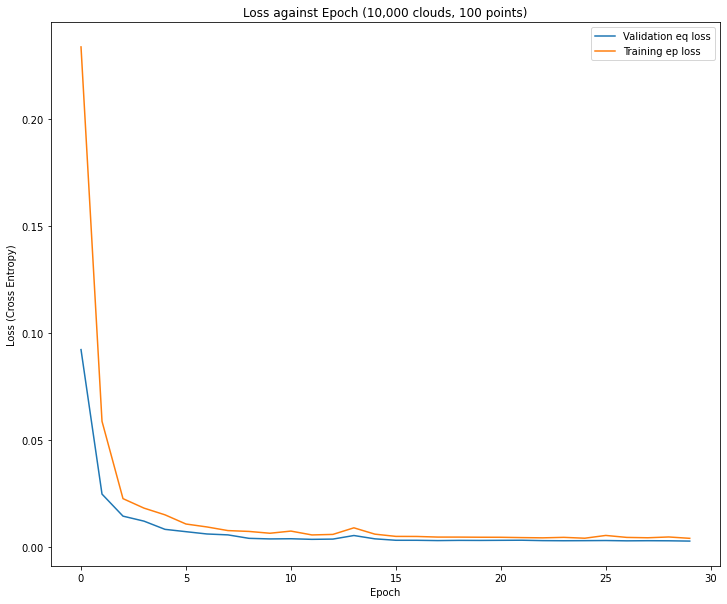

In [7]:
# And another one
plt.figure(figsize=(12,10))
plt.title('Loss against Epoch (10,000 clouds, 100 points)') 
plt.xlabel('Epoch')                                              
plt.ylabel('Loss (Cross Entropy)') 
plt.plot(validep_loss, label = "Validation eq loss")
plt.plot(trainingep_loss, label = "Training ep loss")
plt.legend()